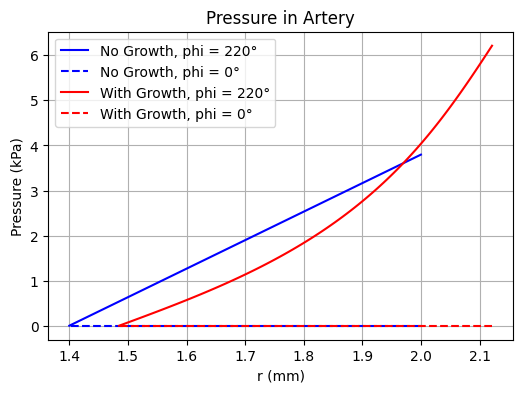

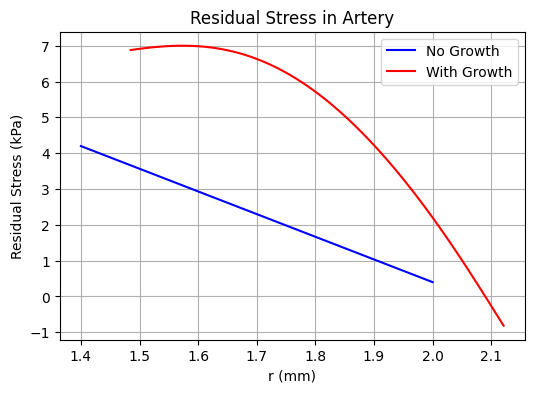

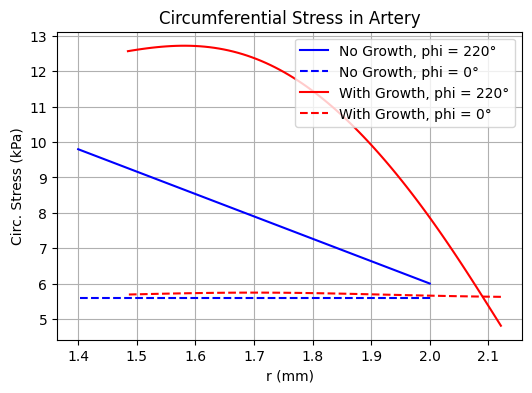

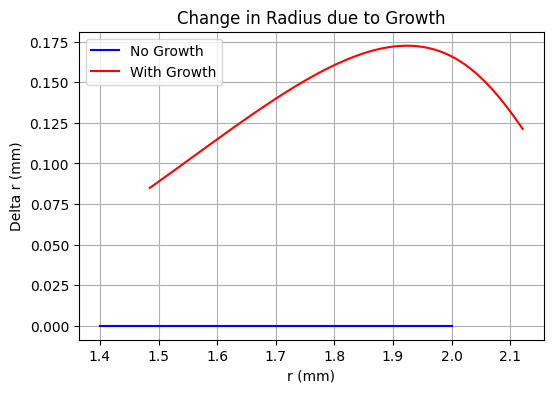

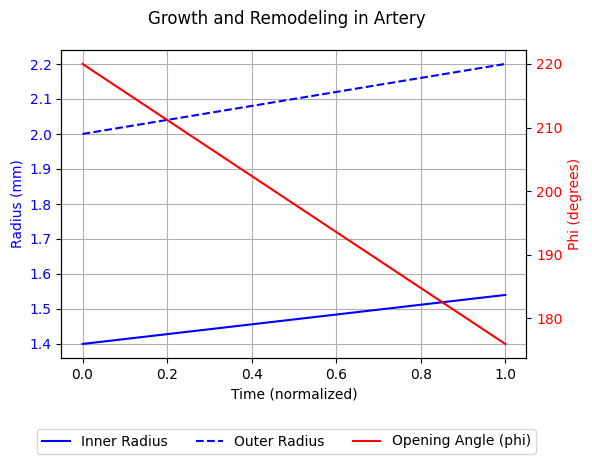

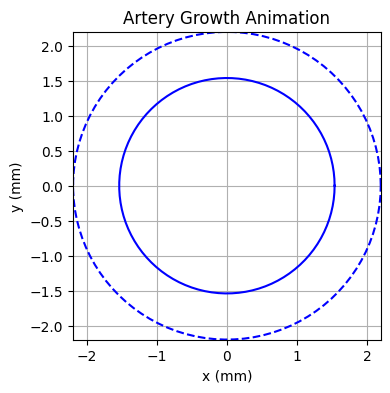

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter

a_0 = 1.4  # Inner radius (mm) in the unloaded state
b_0 = 2.0  # Outer radius (mm) in the unloaded state
phi_0 = 220 * np.pi / 180  # Opening angle (radians), phi = 220 degrees
Lambda_0 = 1.0  # Initial axial stretch ratio

# Material constants
c = 11.2  # kPa
alpha_1 = 0.0499
alpha_2 = 1.0672
alpha_3 = -0.4775

def W(I_1):
    term = I_1 - 3
    return c / 2 * term + alpha_1 * term**2 + alpha_2 * term**3 + alfa_3 * term**4

# Nonlinear Growth Factor (anisotropic growth across radius)
def growth_factor(r):
    return 1 + 0.1 * np.exp(-((r - (a_0 + b_0) / 2) ** 2) / (0.5 * (b_0 - a_0) ** 2))

# Stretch Ratios (considering growth and residual stress)
def stretch_ratios(r, phi, g):
    if abs(phi) < 1e-10:
        lambda_theta = r / r  # No residual stress
        lambda_r = 1.0
    else:
        theta_0 = 2 * np.pi - phi  # Residual circumference
        lambda_theta = (theta_0 / (2 * np.pi)) * (b_0 / (b_0 - a_0)) * (r / (r / g))
        lambda_r = 1 / lambda_theta  # Incompressibility condition
    lambda_z = Lambda_0 * g  # Axial stretch depends on growth
    return lambda_r, lambda_theta, lambda_z

def invariants(lambda_r, lambda_theta, lambda_z):
    I_1 = lambda_r**2 + lambda_theta**2 + lambda_z**2
    return I_1

# Equilibrium Equation for Pressure
def pressure_ode(p, r, phi, g):
    lambda_r, lambda_theta, lambda_z = stretch_ratios(r, phi, g)
    I_1 = invariants(lambda_r, lambda_theta, lambda_z)
    term = I_1 - 3
    dW_dI1 = c / 2 + 2 * alpha_1 * term + 3 * alpha_2 * term**2 + 4 * alpha_3 * term**3
    if np.abs(lambda_r**2 * lambda_theta**2) < 1e-10:
        dp_dr = 0
    else:
        dp_dr = -(lambda_theta**2 - lambda_r**2) / (lambda_r**2 * lambda_theta**2) * dW_dI1
    return dp_dr

# Circumferential Stress
def circ_stress(r, phi, p, g):
    lambda_r, lambda_theta, lambda_z = stretch_ratios(r, phi, g)
    I_1 = invariants(lambda_r, lambda_theta, lambda_z)
    term = I_1 - 3
    dW_dI1 = c / 2 + 2 * alpha_1 * term + 3 * alpha_2 * term**2 + 4 * alpha_3 * term**3
    sigma_theta = lambda_theta**2 * dW_dI1 - p
    return sigma_theta

# Remodeling Function (simulates change in opening angle phi over time)
def remodeling_factor(t):
    return phi_0 * (1 - 0.2 * t)  # Decrease phi by 20% over time

# Radii for Modeling
r_no_growth = np.linspace(a_0, b_0, 100)[::-1]
r_with_growth = np.array([r * growth_factor(r) for r in r_no_growth])

# Pressure and Stress without Growth
p0_220_no_growth = [0]
pressure_phi_220_no_growth = odeint(pressure_ode, p0_220_no_growth, r_no_growth, args=(phi_0, 1.0)).flatten()[::-1]
pressure_phi_0_no_growth = odeint(pressure_ode, p0_220_no_growth, r_no_growth, args=(0, 1.0)).flatten()[::-1]
circ_stress_phi_220_no_growth = np.array([circ_stress(r_i, phi_0, p_i, 1.0) for r_i, p_i in zip(r_no_growth, pressure_phi_220_no_growth)])
circ_stress_phi_0_no_growth = np.array([circ_stress(r_i, 0, p_i, 1.0) for r_i, p_i in zip(r_no_growth, pressure_phi_0_no_growth)])
residual_stress_no_growth = circ_stress_phi_220_no_growth - circ_stress_phi_0_no_growth
delta_r_no_growth = r_no_growth - r_no_growth

# Pressure and Stress with Growth
p0_220_with_growth = [0]
pressure_phi_220_with_growth = odeint(pressure_ode, p0_220_with_growth, r_with_growth, args=(phi_0, growth_factor(r_with_growth.mean()))).flatten()[::-1]
pressure_phi_0_with_growth = odeint(pressure_ode, p0_220_with_growth, r_with_growth, args=(0, growth_factor(r_with_growth.mean()))).flatten()[::-1]
circ_stress_phi_220_with_growth = np.array([circ_stress(r_i, phi_0, p_i, growth_factor(r_i)) for r_i, p_i in zip(r_with_growth, pressure_phi_220_with_growth)])
circ_stress_phi_0_with_growth = np.array([circ_stress(r_i, 0, p_i, growth_factor(r_i)) for r_i, p_i in zip(r_with_growth, pressure_phi_0_with_growth)])
residual_stress_with_growth = circ_stress_phi_220_with_growth - circ_stress_phi_0_with_growth
delta_r_with_growth = r_with_growth - r_no_growth

# Growth and Remodeling Simulation (change in radius and phi over time)
time_steps = np.linspace(0, 1, 100)
r_inner_over_time = [a_0 * (1 + 0.1 * t) for t in time_steps]  # Linear growth for inner radius
r_outer_over_time = [b_0 * (1 + 0.1 * t) for t in time_steps]  # Linear growth for outer radius
phi_over_time = [remodeling_factor(t) * 180 / np.pi for t in time_steps]  # Phi in degrees

plt.figure(figsize=(6, 4))
plt.plot(r_no_growth, pressure_phi_220_no_growth, 'b-', label='No Growth, phi = 220°')
plt.plot(r_no_growth, pressure_phi_0_no_growth, 'b--', label='No Growth, phi = 0°')
plt.plot(r_with_growth, pressure_phi_220_with_growth, 'r-', label='With Growth, phi = 220°')
plt.plot(r_with_growth, pressure_phi_0_with_growth, 'r--', label='With Growth, phi = 0°')
plt.grid(True)
plt.xlabel('r (mm)')
plt.ylabel('Pressure (kPa)')
plt.title('Pressure in Artery')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(r_no_growth, residual_stress_no_growth, 'b-', label='No Growth')
plt.plot(r_with_growth, residual_stress_with_growth, 'r-', label='With Growth')
plt.grid(True)
plt.xlabel('r (mm)')
plt.ylabel('Residual Stress (kPa)')
plt.title('Residual Stress in Artery')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(r_no_growth, circ_stress_phi_220_no_growth, 'b-', label='No Growth, phi = 220°')
plt.plot(r_no_growth, circ_stress_phi_0_no_growth, 'b--', label='No Growth, phi = 0°')
plt.plot(r_with_growth, circ_stress_phi_220_with_growth, 'r-', label='With Growth, phi = 220°')
plt.plot(r_with_growth, circ_stress_phi_0_with_growth, 'r--', label='With Growth, phi = 0°')
plt.grid(True)
plt.xlabel('r (mm)')
plt.ylabel('Circ. Stress (kPa)')
plt.title('Circumferential Stress in Artery')
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(r_no_growth, delta_r_no_growth, 'b-', label='No Growth')
plt.plot(r_with_growth, delta_r_with_growth, 'r-', label='With Growth')
plt.grid(True)
plt.xlabel('r (mm)')
plt.ylabel('Delta r (mm)')
plt.title('Change in Radius due to Growth')
plt.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(time_steps, r_inner_over_time, 'b-', label='Inner Radius')
ax1.plot(time_steps, r_outer_over_time, 'b--', label='Outer Radius')
ax1.set_xlabel('Time (normalized)')
ax1.set_ylabel('Radius (mm)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(time_steps, phi_over_time, 'r-', label='Opening Angle (phi)')
ax2.set_ylabel('Phi (degrees)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

fig.suptitle('Growth and Remodeling in Artery')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=3)
plt.show()

fig, ax = plt.subplots(figsize=(6, 4))
theta = np.linspace(0, 2 * np.pi, 100)
line_inner, = ax.plot([], [], 'b-')
line_outer, = ax.plot([], [], 'b--')
ax.set_xlim(-2.2, 2.2)
ax.set_ylim(-2.2, 2.2)
ax.grid(True)
ax.set_aspect('equal')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')
ax.set_title('Artery Growth Animation')

def init():
    line_inner.set_data([], [])
    line_outer.set_data([], [])
    return line_inner, line_outer,

def update(frame):
    g_t = 1 + 0.1 * frame / 100  # Linear growth from 1 to 1.1
    r_inner = a_0 * g_t
    r_outer = b_0 * g_t
    x_inner = r_inner * np.cos(theta)
    y_inner = r_inner * np.sin(theta)
    x_outer = r_outer * np.cos(theta)
    y_outer = r_outer * np.sin(theta)
    line_inner.set_data(x_inner, y_inner)
    line_outer.set_data(x_outer, y_outer)
    return line_inner, line_outer,

ani = FuncAnimation(fig, update, frames=100, init_func=init, blit=True, interval=50)
writer = PillowWriter(fps=20)
ani.save("artery_growth_animation.gif", writer=writer)
plt.show()